## Description

This code create a table of results that can be used to measure the FIRC. It's aim is to create a table for each of the LOFAR deep fields that contains all the information contained in the LOFAR radio and optical catalogues. It will also add the SED information from the different SED fitting codes into the table and calculate Q for each of these codes. It will also add the AGN classifictaion information in as well when that becomes available.

This code will not create a sample that can be used to measure teh FIRC that will be left to the code that calculates the FIRC.

In [10]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join,MaskedColumn
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc,flux_to_mag
import pymoc
from pymoc.io.fits import read_moc_fits

from astropy.io import registry
from astropy.table.info import serialize_method_as

In [11]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [12]:
def get_good_sed_fit_mask(catalogue,sed_fitting_code):
    #returns a mask that identifies good fits from a given results table from one of the four SED fitting codes
    #Magphys, AGNfitter, CIGALE and BAGPIPES
    '''if sed_fitting_code != ('magphys' or 'agnfitter' or 'cigale' or 'bagpipes'):
        print('catalogue not associtaed with any known sed fitter. Please provide SED fitter')
        return()'''
    #returns the magphys mask using the chi2_99_flag column which is described in Smith et al 2012
    if sed_fitting_code=='magphys':
        mask = ~(catalogue['chi2_99_flag']==1.0)
        return(mask)
    #need to write AGN fitter section
    elif sed_fitting_code=='agnfitter':
        print('agnfitter')
        mask = catalogue['goodAF'].data.data
        return(mask)
    #need to write CIGALE section
    #need to write BAGPIPES section
    else:
        print('catalogue not associtaed with any known sed fitter. Please provide SED fitter')
        mask = np.ones(len(catalogue)).astype(bool)
        return(mask)

In [13]:
#Read in the LOFAR catalogue
lofar_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar_bootes = Table.read('../../lofar/deep_fields/Bootes/data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar_lockman = Table.read('../../lofar/deep_fields/Lockman/data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar_en1[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,flo

In [111]:
#read in the LOFAR SED fits for EN1
magphys_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/magphys/ELAIS_N1_lowzmagphys_20200219.fits')
#cigale_en1 = Table.read('')
#need to write some code to change the units of ldust to watts here so the merged ldust catatlogue
#has consistent units in all teh ldust cols
magphys_cols = ['galaxy_id','Ldust_best','Ldust_sigma','Ldust_bayes','Ldust_03','Ldust_16','Ldust_50','Ldust_84','Ldust_98','SFR_bayes','chi2','chi2_99_flag']
magphys_ldust = [magphys_en1[magphys_cols]]
#magphys_ldust.rename_column('galaxy_id','Source_Name')

for n,cat in enumerate(magphys_ldust):
    magphys_ldust[n].rename_column('galaxy_id','Source_Name')
    mask = get_good_sed_fit_mask(magphys_ldust[n],'magphys')
    mask = magphys_ldust[n]['chi2_99_flag']==0
    magphys_ldust[n] = magphys_ldust[n][mask]
    for m,name in enumerate(magphys_cols):
        if m==0:
            continue
        if 'chi' in name:
            continue
        magphys_ldust[n][name] = magphys_ldust[n][name]*3.8*10**26
        magphys_ldust[n][name] = magphys_ldust[n][name].astype(float)
        

magphys_ldust[0][0]

Source_Name,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int16
ILTJ161340.59+535110.1,2.1576399034777602e+40,4.8886320201728e+39,2.52396722716672e+40,1.7369351061504e+40,2.04072082735104e+40,2.51063504470016e+40,3.01844697972736e+40,3.4656409878528e+40,2.3493693359375e+30,10.601,0


In [117]:
magphys_en1[0]

galaxy_id,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98
bytes30,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ161340.59+535110.1,5.7147,10.601,0,0.397,0.036,0.3823376,0.322,0.344,0.381,0.416,0.474,0.298,0.0815,0.32935956,0.197,0.254,0.314,0.417,0.511,0.742,0.127,0.59456086,0.392,0.46,0.581,0.714,0.802,2.475,0.715,3.395226,2.297,2.672,3.367,4.102,4.832,7.457e-09,1.7419937e-09,7.08084e-09,2.9853826e-09,5.9566214e-09,7.498942e-09,9.440609e-09,1.05925375e-08,714700000000.0,222967740000.0,899170000000.0,588843650000.0,676083000000.0,831763800000.0,1122018400000.0,1621810100000.0,56780000000000.0,12864822000000.0,66420193000000.0,45708820000000.0,53703180000000.0,66069344000000.0,79432820000000.0,91201080000000.0,15.4,2.1375,17.73205,15.063,15.513,17.088,19.788,23.588,58.8,5.225,53.33732,36.663,48.138,54.788,58.588,59.788,0.171,0.056,0.21583506,0.123,0.158,0.209,0.27,0.364,0.414,0.0765,0.34064528,0.205,0.268,0.338,0.421,0.484,0.185,0.163,0.2652139,0.035,0.1,0.263,0.426,0.546,0.23,0.084,0.17695282,0.043,0.091,0.177,0.259,0.33,1.836,0.175,1.9509562,1.582,1.787,1.902,2.137,2.302,137900000000.0,83765590000.0,121292310000.0,10399201000.0,35237085000.0,101624870000.0,202768270000.0,368977600000.0,5330.0,1263.4622,6182.551,4045.759,4920.3955,6053.4087,7447.32,8649.679


In [15]:
agnfitter_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/agnfitter/EN1_agnfitter_out_calc.v1.fits')

agnfitter_cols = ['Source_Name','LIR_8_1000_med','LIR_8_1000_p16','LIR_8_1000_p84','LIR_8_1000_ml','LIR','LIR_em','LIR_ep','logL150','goodAF','ln_l','q150']
agnfitter_ldust = [agnfitter_en1[agnfitter_cols]]

for n,cat in enumerate(agnfitter_ldust):
    mask = get_good_sed_fit_mask(cat,'agnfitter')
    agnfitter_ldust[n] = agnfitter_ldust[n][mask]
    for name in cat.colnames:
        if '_1000_' in name:
            cat[name] = cat[name]-7

agnfitter_ldust[0][0]

agnfitter


Source_Name,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64
ILTJ155957.58+550052.4,46.108,45.7237,46.3398,46.3007,1.2823305826560126e+39,1.1347131116081786e+39,6.844301308112887e+38,24.936400893185994,True,-12.1933,1.5975678390862846


In [16]:
def fritz_cigale_read(results_name,input_name,field):
    
    results_tbl = Table.read('../../lofar/deep_fields/{}/data/cigale_fritz/{}'.format(field,results_name))
    results_col = ['id','bayes.dust.luminosity','bayes.dust.luminosity_err','best.reduced_chi_square']
    results_tbl = results_tbl[results_col]
    
    input_tbl = Table.read('../../lofar/deep_fields/{}/data/cigale_fritz/{}'.format(field,input_name))
    col_num = Column(name='id',data=np.arange(0,len(input_tbl),1))
    input_tbl.add_column(col_num)
    input_cols = ['Source_Name','id']
    input_tbl = input_tbl[input_cols]
    
    fritz_final = join(input_tbl,results_tbl,join_type='inner',keys='id')
    
    fritz_final.remove_column('id')
    for name in fritz_final.colnames:
        if name=='Source_Name':
            continue
        fritz_final.rename_column(name,name+'_fritz')
    
    return(fritz_final)
    
    

In [17]:
output_names = ['lofar_team_test_cigale.fits']
input_names = ['EN1_sedfit.fits']
fields = ['ELAIS-N1']

fritz_ldust = []
for n in range(len(output_names)):
    fritz_ldust.append(fritz_cigale_read(output_names[n],input_names[n],fields[n]))

fritz_ldust[0][0]

Source_Name,bayes.dust.luminosity_fritz,bayes.dust.luminosity_err_fritz,best.reduced_chi_square_fritz
bytes22,float64,float64,float64
ILTJ155957.58+550052.4,7.317707324974108e+38,1.6649764474469281e+38,2.1912198918275254


In [18]:
skirtor_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/cigale_skirtor/final_results.fits')

skirtor_cols = ['Source_Name','bayes.dust.luminosity','bayes.dust.luminosity_err','best.reduced_chi_square']
skirtor_ldust = [skirtor_en1[skirtor_cols]]

for n,cat in enumerate(skirtor_ldust):
    mask = get_good_sed_fit_mask(cat,'cigale')
    skirtor_ldust[n] = skirtor_ldust[n][mask]
    for name in cat.colnames:
        if name=='Source_Name':
            continue
        skirtor_ldust[n].rename_column(name,name+'_skirtor')

skirtor_ldust[0][0]

catalogue not associtaed with any known sed fitter. Please provide SED fitter


Source_Name,bayes.dust.luminosity_skirtor,bayes.dust.luminosity_err_skirtor,best.reduced_chi_square_skirtor
bytes22,float64,float64,float64
ILTJ155957.58+550052.4,9.292985542614325e+38,8.161276258575593e+37,2.7493806955731377


In [8]:
bagpipes_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/bagpipes/cat/bagpipes_en1_wendycat.fits')
bagpipes_bootes = Table.read('../../lofar/deep_fields/Bootes/data/bagpipes/cat/bagpipes_bootes_wendycat.fits')
bagpipes_lh = Table.read('../../lofar/deep_fields/Lockman/data/bagpipes/cat/bagpipes_lh_wendycat.fits')

In [9]:
bagpipes_en1[0]

ID,dblplaw:alpha_16,dblplaw:alpha_50,dblplaw:alpha_84,dblplaw:beta_16,dblplaw:beta_50,dblplaw:beta_84,dblplaw:massformed_16,dblplaw:massformed_50,dblplaw:massformed_84,dblplaw:metallicity_16,dblplaw:metallicity_50,dblplaw:metallicity_84,dblplaw:tau_16,dblplaw:tau_50,dblplaw:tau_84,dust:Av_16,dust:Av_50,dust:Av_84,dust:gamma_16,dust:gamma_50,dust:gamma_84,dust:qpah_16,dust:qpah_50,dust:qpah_84,dust:umin_16,dust:umin_50,dust:umin_84,stellar_mass_16,stellar_mass_50,stellar_mass_84,formed_mass_16,formed_mass_50,formed_mass_84,sfr_16,sfr_50,sfr_84,ssfr_16,ssfr_50,ssfr_84,nsfr_16,nsfr_50,nsfr_84,mass_weighted_age_16,mass_weighted_age_50,mass_weighted_age_84,tform_16,tform_50,tform_84,tquench_16,tquench_50,tquench_84,input_redshift,log_evidence,log_evidence_err,chisq,chisq_red,chisq_arr,chisq_sign_arr
float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes317,bytes106
26455.0,0.021924374093866997,0.08707439684221173,0.43018605826005296,0.11516519436213493,6.1818625311907685,171.1935240172921,10.96521794556997,11.092576356901422,11.164601764915755,0.1914910056002704,0.3535583085259861,0.6207662816072386,1.1119302190259952,2.6035729964988854,4.0876028813870775,1.648172433514807,1.7445927729847452,1.8653090483091923,0.10939252431823768,0.3124919124649958,0.5740632737467383,1.6708688396378866,2.763673229101181,3.7142127315941575,4.902379949685022,11.892425868506631,19.913899575403335,10.749292550701732,10.850452927570602,10.915355402425511,10.98611476268605,11.115104225069036,11.18668810460984,23.682484659129447,27.60036277738573,34.1459098222695,-9.499748654058822,-9.423974651914142,-9.233566553114736,-0.012116985036643513,0.0753012325639224,0.2968237102719213,1.4477919803245984,2.4318790860512083,2.8912836220409144,2.8870849976320705,3.3464895336217784,4.330576639348386,99.0,99.0,99.0,0.9933,631.5970763426128,0.16756168954780942,20.177,1.345,[3.572 0.015 2.384 0.116 0.781 0.141 2.303 1.316 0.52 0.007 1.246 0. 0. 0.132 1.888 0.725 0.026 0.087 0.446 0.122 0.056 0.491 2.364 1.291 0.048 0.1 ],[ 1. -1. 1. 1. -1. -1. -1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -1. 1. 1. -1. -1. -1. -1. -1. -1.]


In [112]:
#join the SED catalogues with the LOFAR table

SED_tables_en1 = [magphys_ldust[0],agnfitter_ldust[0],fritz_ldust[0],skirtor_ldust[0]]
print('lofar table has {} sources'.format(len(lofar_en1)))
for n,catalogue in enumerate(SED_tables_en1):
    if n==0:
        lofar_sed_en1 = join(lofar_en1,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_en1)))
    else:
        lofar_sed_en1 = join(lofar_sed_en1,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_en1)))
        
'''SED_tables_bootes = [magphys_ldust[1],agnfitter_ldust[1],fritz_ldust[1],skirter_ldust[1]]
print('lofar table has {} sources'.format(len(lofar_bootes)))
for n,catalogue in enumerate(SED_tables_bootes):
    if n==0:
        lofar_sed_bootes = join(lofar_bootes,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed)))
    else:
        lofar_sed_bootes = join(lofar_sed_bootes,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed)))
        
        
SED_tables_lh = [magphys_ldust[2],agnfitter_ldust[2],fritz_ldust[2],skirter_ldust[2]]
print('lofar table has {} sources'.format(len(lofar_lh)))
for n,catalogue in enumerate(SED_tables_lh):
    if n==0:
        lofar_sed_lh = join(lofar_lh,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed)))
    else:
        lofar_sed_lh = join(lofar_sed_lh,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed)))'''
    
lofar_sed_en1[0]

lofar table has 31645 sources
new joined table has 31645 sources


new joined table has 31645 sources
new joined table has 31645 sources


new joined table has 31645 sources


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,bayes.dust.luminosity_fritz,bayes.dust.luminosity_err_fritz,best.reduced_chi_square_fritz,bayes.dust.luminosity_skirtor,bayes.dust.luminosity_err_skirtor,best.reduced_chi_square_skirtor
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


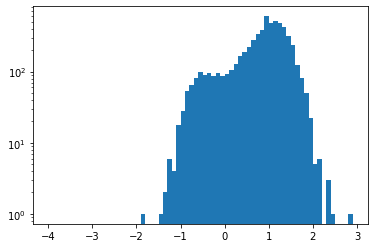

In [118]:
y = np.log10(lofar_sed_en1['SFR_bayes']/(3.8*10**26))
mask = (lofar_sed_en1['Z_BEST']<1) & (lofar_sed_en1['Mass_median']>10.7)
y = y[mask]
bins=np.arange(-4,3,0.1)

plt.hist(y,bins=bins,log=True)
plt.show()

In [116]:
lofar_sed_en1['SFR_bayes']

--
1.2036447143554687e+28
6.98279266357422e+27
9.681786346435548e+27
3.62746875e+29
1.9807037353515626e+28
7.953919219970704e+27
4.628555774688721e+26
1.867167115211487e+26
3.531715869903565e+26
4.3821407318115234e+27


In [20]:
dust_lum_names = ['Ldust_bayes','LIR','bayes.dust.luminosity_fritz','bayes.dust.luminosity_skirtor']
sed_name = ['magphys','agnfitter','fritz','skirtor']



catalogues = [lofar_sed_en1]
for n,catalogue in enumerate(catalogues):

    radio_flux = catalogues[n]['Total_flux'].data.data
    redshift = catalogues[n]['Z_BEST'].data.data
    dist = cosmo.luminosity_distance(redshift).to(u.m).value

    alpha = -0.7
    radio_lum = radio_flux*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)
    radio_lum_col = MaskedColumn(name='radio_luminosity',data=radio_lum)
    catalogues[n].add_column(radio_lum_col)

    for m,name in enumerate(dust_lum_names):

        if name=='Ldust_bayes':
            dust_lum = []
            for l,num in enumerate(catalogues[n][name]):
                dust_lum.append(num)
            dust_lum = np.array(dust_lum)
            print(dust_lum)
        else:
            dust_lum = catalogues[n][name].data.data

        q = np.log10(dust_lum/3.75E12) - np.log10(radio_lum)
        q_col = MaskedColumn(name='q_'+sed_name[m], data=q)
        catalogues[n].add_column(q_col)
        
lofar_sed_en1[0]

[           nan 1.59859029e+38 2.30103581e+38 ... 5.50103207e+38
 9.74052786e+37            nan]


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Warning: converting a masked element to nan.
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,bayes.dust.luminosity_fritz,bayes.dust.luminosity_err_fritz,best.reduced_chi_square_fritz,bayes.dust.luminosity_skirtor,bayes.dust.luminosity_err_skirtor,best.reduced_chi_square_skirtor,radio_luminosity,q_magphys,q_agnfitter,q_fritz,q_skirtor
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,fl

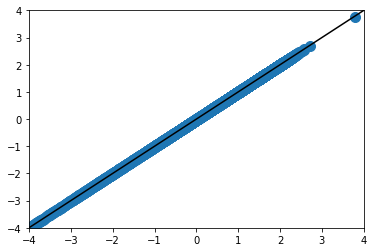

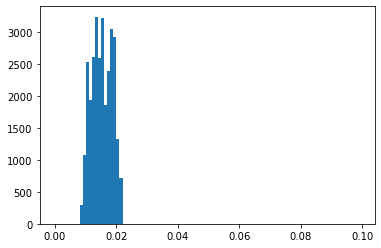

In [29]:
x = lofar_sed_en1['q150']
y = lofar_sed_en1['q_agnfitter']
plt.scatter(x,y,s=100)
plt.plot([-4,4],[-4,4],c='black')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()

plt.hist(x-y,bins=np.arange(0.0,0.1,0.001))
plt.show()

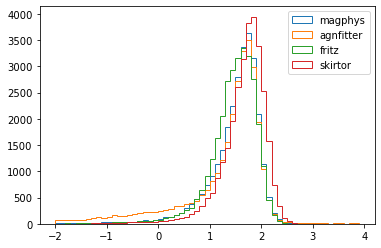

In [262]:
bins = np.arange(-2,4,0.1)
y = lofar_sed_en1['q_magphys']
plt.hist(y,bins=bins,histtype='step',label='magphys')

y = lofar_sed_en1['q_agnfitter']
plt.hist(y,bins=bins,histtype='step',label='agnfitter')

y = lofar_sed_en1['q_fritz']
plt.hist(y,bins=bins,histtype='step',label='fritz')

y = lofar_sed_en1['q_skirtor']
plt.hist(y,bins=bins,histtype='step',label='skirtor')

plt.legend()
plt.show()

In [53]:
#Finally add the AGN classifications 
#create a AGN mask that can be applied to the detected sample table
agn_table = Table.read('../../lofar/deep_fields/ELAIS-N1/data/data_release/AGNclasses_v2.txt',format='ascii')
agn_table[0]

print(len(lofar_sed_en1))

lofar_sed_en1 = join(lofar_sed_en1,agn_table,keys='Source_Name')
print(len(lofar_sed_en1))
lofar_sed_en1[0]

31645
31645


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,bayes.dust.luminosity_fritz,bayes.dust.luminosity_err_fritz,best.reduced_chi_square_fritz,bayes.dust.luminosity_skirtor,bayes.dust.luminosity_err_skirtor,best.reduced_chi_square_skirtor,radio_luminosity,q_magphys,q_agnfitter,q_fritz,q_skirtor,optical_AGN_1,radio_AGN_1,rad_excess_1,optical_AGN_2,radio_AGN_2,rad_excess_2
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str30,float64,float64,float64

In [52]:
#write the tables

with serialize_method_as(lofar_sed_en1, None):
            registry.write(lofar_sed_en1,'data/lofar_sed_en1.fits',format='fits',overwrite=True)

<class 'astropy.table.table.Table'>
fits


compare fluxes against Calistro Rivera bootes data

In [42]:
rivera_data = Table.read('../../lofar/deep_fields/Bootes/data/CR17_LOFARpaper_alldata.fits')
rivera_data[0]

ras = rivera_data['RA']
decs = rivera_data['DEC']
rivera_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)

ras = lofar_bootes['RA']
decs = lofar_bootes['DEC']
lofar_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)

idx,d2d,_ = rivera_coords.match_to_catalog_sky(lofar_coords)

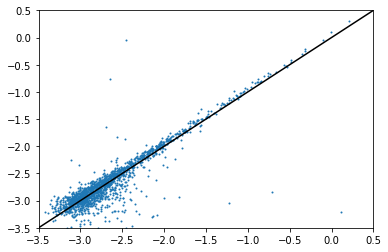

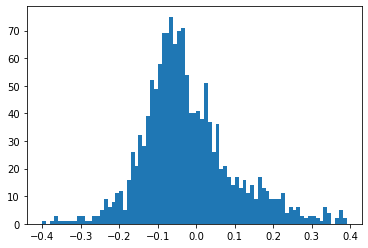

In [50]:
x = np.log10(rivera_data['LOFARtotflux'])
y = np.log10(lofar_bootes['Total_flux'][idx])
plt.scatter(x,y,s=1)
plt.plot([-3.5,0.5],[-3.5,0.5],c='black')
plt.xlim(-3.5,0.5)
plt.ylim(-3.5,0.5)
plt.show()

bins=np.arange(-0.4,0.4,0.01)
plt.hist(x-y,bins=bins)
plt.show()

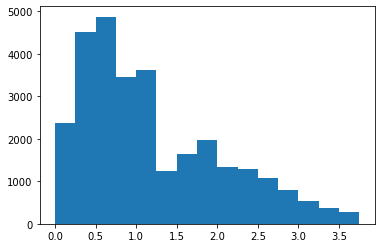

In [57]:
#Look at redshift distribution
bins=np.arange(0,4,0.25)
y = lofar_sed_en1['Z_BEST']
plt.hist(y,bins=bins)
plt.show()

In [ ]:
y = np.log10(lofar_sed_en1[''])

## Create catalogues for the non detection in the radio

In [59]:
stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

In [60]:
magphys_all_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/magphys/ELAIS_N1.fits')
magphys_all_en1.rename_column('galaxy_id','ID')

print(len(magphys_all_en1))

magphys_cols = ['galaxy_id','Ldust_best','Ldust_sigma','Ldust_bayes','Ldust_03','Ldust_16','Ldust_50','Ldust_84','Ldust_98','chi2','chi2_99_flag']

mask = get_good_sed_fit_mask(magphys_all_en1,'magphys')
magphys_all_en1 = magphys_all_en1[mask]
for m,name in enumerate(magphys_cols):
    if m==0:
        continue
    if 'chi' in name:
        continue
    magphys_all_en1[name] = magphys_all_en1[name]*3.8*10**26
    magphys_all_en1[name] = magphys_all_en1[name].astype(float)

print(len(magphys_all_en1))
magphys_all_en1[0]

183399
162289


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98
int32,float64,float32,int16,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
100000,1.4748,1.625,0,0.853,0.131,0.6552859,0.271,0.528,0.673,0.79,0.884,0.736,0.164,0.6630925,0.288,0.502,0.678,0.83,0.943,0.153,0.192,0.25345436,0.028,0.07,0.21,0.454,0.751,2.084,1.3625,2.2774367,0.472,0.987,2.107,3.712,4.812,8.049e-12,2.7239069e-11,4.7997082e-11,8.51138e-12,2.137962e-11,3.801894e-11,7.585776e-11,1.3335215e-10,66770002000.0,12675847200.0,50863047000.0,29512091600.0,36307804000.0,51286139000.0,61659501000.0,75857756000.0,8.778000114000001e+36,1.0350845688000001e+37,1.763592236e+37,4.3629838700000004e+36,8.124255942e+36,1.3482908440000001e+37,2.882594728e+37,5.126058944e+37,24.6,3.425,20.04573,15.238,16.588,20.088,23.438,24.738,57.1,10.2625,45.071186,30.713,34.838,45.063,55.363,59.263,0.559,0.177,0.5430918,0.199,0.368,0.547,0.722,0.861,0.112,0.079,0.122827895,0.015,0.043,0.106,0.201,0.335,0.059,0.064,0.09698471,0.011,0.031,0.076,0.159,0.323,0.27,0.15,0.23704752,0.026,0.087,0.221,0.387,0.553,0.318,0.245,0.43633643,0.062,0.207,0.372,0.697,1.052,11100000.0,97021720.0,122656248.0,5584702.0,18281002.0,61235040.0,212324448.0,619441090.0,0.5375,1.2562747,2.3892372,0.5395106,1.0519619,2.004472,3.5645113,7.112135


In [101]:
#join with Kens catalogue to get stellar masses for these sources
magphys_stellar_mass_en1 = join(magphys_all_en1,stellar_mass_cat,keys='ID',join_type='inner')
magphys_stellar_mass_en1[0]

ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float32,int16,float32,float32,float64,float32,float32,float32,flo

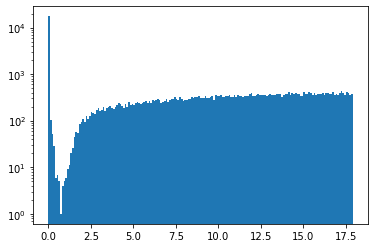

57.325377780660226% of LOFAR sources have a magphys source within 1.0 arcseconds
144611


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float32,int16,float32,float32,float64,float32,float32,float32,flo

In [102]:
#remove sources that are already detected in the LOFAR catalogue

ras = magphys_stellar_mass_en1['RA']
decs = magphys_stellar_mass_en1['DEC']

high_mass_coords = SkyCoord(ra=ras,dec=decs)

mask = ~np.isnan(lofar_sed_en1['optRA'])
ras = lofar_sed_en1['optRA'][mask]
decs = lofar_sed_en1['optDec'][mask]
help_ldust_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)

idx,d2d,_ = high_mass_coords.match_to_catalog_sky(help_ldust_coords)

d2d = d2d.value*3600
plt.hist(d2d,bins=np.arange(0,18,0.1),log=True)
plt.show()

sep_dist = 1.0
print('{}% of LOFAR sources have a magphys source within {} arcseconds'.format(np.sum(d2d<sep_dist)/np.sum(mask)*100,sep_dist))

mask = d2d<sep_dist
magphys_stellar_mass_en1 = magphys_stellar_mass_en1[~mask]

print(len(magphys_stellar_mass_en1))
magphys_stellar_mass_en1[0]

In [103]:
#Read in the LOFAR and HERschel maps
fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header).celestial
radim_err = hdulist[0].data[0][0]
hdulist.close()

  'HZ' -> 'Hz'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'.


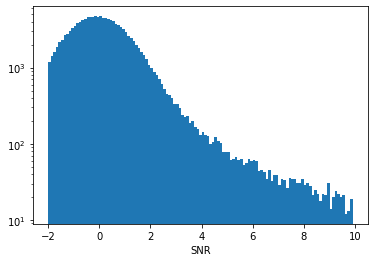

In [104]:
#Calculate upper limits on the radio flux from the LOFAR image for the HELP objects
ras = magphys_stellar_mass_en1['RA']
decs = magphys_stellar_mass_en1['DEC']

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_flux = radim_data[x,y]

x,y = np.round(radim_wcs_err.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_errs = radim_err[x,y]

rad_upper_lims = rad_errs*5

SNR = rad_flux/rad_errs
bins = np.arange(-2,10,0.1)
plt.hist(SNR,bins=bins,log=True)

plt.xlabel('SNR')
plt.show()

rad_f_aper_col = Column(name='radio_flux_pixel',data=rad_flux)
rad_f_lim_col = Column(name='radio_flux_limit',data=rad_upper_lims)
magphys_stellar_mass_en1.add_columns([rad_f_aper_col,rad_f_lim_col])

In [105]:
redshift = magphys_stellar_mass_en1['Z_BEST']
dist = cosmo.luminosity_distance(redshift).to(u.m).value

alpha = -0.7
radio_lum_upper = rad_upper_lims*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)
radio_lum_aperture = rad_flux*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)

radio_lum_aper_col = Column(name='radio_luminosity_pixel',data=radio_lum_aperture)
radio_lum_upper_col = Column(name='radio_luminosity_limit',data=radio_lum_upper)
magphys_stellar_mass_en1.add_columns([radio_lum_aper_col,radio_lum_upper_col])

In [106]:
ldust = magphys_stellar_mass_en1['Ldust_bayes']

q_lim = np.log10(ldust/3.75E12) - np.log10(radio_lum_upper)
q_pixel = np.log10(ldust/3.75E12) - np.log10(radio_lum_aperture)

q_pixel_col = MaskedColumn(name='q_pixel',data=q_pixel,fill_value=np.nan)
q_lim_col = MaskedColumn(name='q_lim',data=q_lim,fill_value=np.nan)
magphys_stellar_mass_en1.add_columns([q_pixel_col,q_lim_col])

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


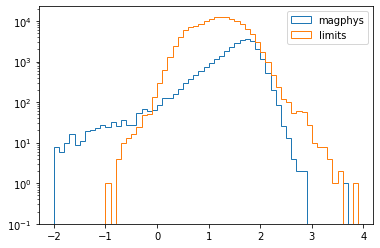

In [107]:
bins = np.arange(-2,4,0.1)
y = lofar_sed_en1['q_magphys']
plt.hist(y,bins=bins,histtype='step',label='magphys',log=True)

plt.hist(q_lim,bins=bins,histtype='step',label='limits',log=True)
plt.legend()
plt.show()

In [108]:
magphys_stellar_mass_en1[0]

ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,m

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


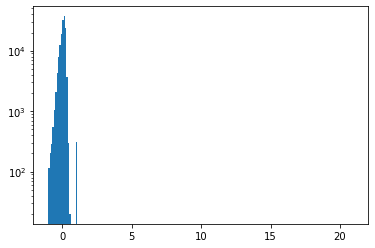

In [109]:
y = np.log10(magphys_stellar_mass_en1['q_lim'])
bins = np.arange(-1,21,0.1)
plt.hist(y,bins=bins,log=True)
plt.show()

In [110]:
with serialize_method_as(magphys_stellar_mass_en1, None):
            registry.write(magphys_stellar_mass_en1,'data/magphys_mass_radio_limits_en1.fits',format='fits',overwrite=True)

<class 'astropy.table.table.Table'>
fits
